### After data has been processed in U-SQL and stored in Azure Blob, you can use Python to build machine learning models and web service API following the steps below:

- Step 0. Import packages 
- Step 1. Read in the Data from blob
- Step 2. Check basic statistics of this data set
- Step 3. Missing Value Handling
- Step 4. Data Exploration in a single variable
- Step 5. Explore the relationship between two or more columns
- Step 6. Feature engineering
- Step 7. Build Machine Learning Models
- Step 8. Build Web Service API and consume it in Python


###Step 0. import  packages

In [61]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import time
import pyodbc
import os
from azure.storage.blob import BlobService
import tables
import time
import zipfile
import random
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from __future__ import division
from sklearn import linear_model
from azureml import services

%matplotlib inline

###Step 1. Read in the Data from blob

In [62]:
#Connection String
CONTAINERNAME = 'test1'
STORAGEACCOUNTNAME = 'weigstoragefordsvm'
STORAGEACCOUNTKEY = 'FUyNCM83pY4K2srBfZv4yDr6ru7d+BfbmHPPtucqS7EIgvUSQBG4zPkznpCuClWVOMitAQXG3aJFbvuD7mBkhQ=='
BLOBNAME = 'demo_ex_9_stratified_1_1000_copy.csv'

blob_service = BlobService(account_name=STORAGEACCOUNTNAME,account_key=STORAGEACCOUNTKEY)

#Read in as text
t1 = time.time()
data = blob_service.get_blob_to_text(CONTAINERNAME,BLOBNAME).split("\n")
t2 = time.time()
print(("It takes %s seconds to read in "+BLOBNAME) % (t2 - t1))

#Add column names and separate columns
colnames = ['medallion','hack_license','vendor_id','rate_code','store_and_fwd_flag','pickup_datetime','dropoff_datetime',
'passenger_count','trip_time_in_secs','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tolls_amount',  'total_amount', 'tip_amount', 'tipped', 'tip_class', 'rownum']

df1 = pd.DataFrame([sub.split(",") for sub in data], columns = colnames)

#Change some columns to numeric
cols_2_float = ['trip_time_in_secs','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
'fare_amount', 'surcharge','mta_tax','tolls_amount','total_amount','tip_amount', 'passenger_count','trip_distance'
,'tipped','tip_class','rownum']
for col in cols_2_float:
    df1[col] = df1[col].astype(float)


It takes 2.6714630127 seconds to read in demo_ex_9_stratified_1_1000_copy.csv


###Step 2. Check basic statistics of this data set

In [63]:
#Check the data frame
print df1.head(5)
print df1.tail(5)
print df1.shape

                            medallion                        hack_license  \
0  "08BAA2264C1C39B35299406F58E14598"  "F664D1573DECA9A5882310DA6E717337"   
1  "0053334C798EC6C8E637657962030F99"  "9EF690115D60940E7A8039A67542642E"   
2  "024A0232F4905854035179D87C8BEAAA"  "28C5A9259CE80BCF953D855C58AF649E"   
3  "275454BAC5AEC63B0730FFEE2E915175"  "F665D8F3D7C62A7EE679CDF4394BACDD"   
4  "09459F826A44348760E74FCD3BFBDB72"  "5D2FE6803D43C44A4F21C7389B5D97D7"   

  vendor_id rate_code store_and_fwd_flag              pickup_datetime  \
0     "CMT"       "1"                "N"  2013-04-23T13:56:00.0000000   
1     "VTS"       "2"                 ""  2013-01-26T18:55:00.0000000   
2     "CMT"       "1"                "N"  2013-09-25T15:13:28.0000000   
3     "VTS"       "1"                 ""  2013-10-03T22:34:00.0000000   
4     "VTS"       "1"                 ""  2013-07-28T14:01:00.0000000   

              dropoff_datetime  passenger_count  trip_time_in_secs  \
0  2013-04-23T14:04:00.00000

In [64]:
#The last row of data is na, remove it
df1 = df1.iloc[0:len(df1)-2,:]

#Remove the quote in some columns
df1.medallion = df1.medallion.str.replace('"','')
df1.hack_license = df1.hack_license.str.replace('"','')
df1.vendor_id = df1.vendor_id.str.replace('"','')
df1.rate_code = df1.rate_code.str.replace('"','')
df1.store_and_fwd_flag = df1.store_and_fwd_flag.str.replace('"','')
df1.payment_type = df1.payment_type.str.replace('"','')

print 'the size of the data is: %d rows and  %d columns' % df1.shape

the size of the data is: 170239 rows and  24 columns


In [65]:
#Check several columns in row 101
df1.ix[101, ['vendor_id', 'passenger_count', 'trip_time_in_secs', 'trip_distance']]

vendor_id              VTS
passenger_count          1
trip_time_in_secs     2280
trip_distance        10.21
Name: 101, dtype: object

In [66]:
# Show column names and types of the data frame
for col in df1.columns:
    print df1[col].name, ':\t', df1[col].dtype

medallion :	object
hack_license :	object
vendor_id :	object
rate_code :	object
store_and_fwd_flag :	object
pickup_datetime :	object
dropoff_datetime :	object
passenger_count :	float64
trip_time_in_secs :	float64
trip_distance :	float64
pickup_longitude :	float64
pickup_latitude :	float64
dropoff_longitude :	float64
dropoff_latitude :	float64
payment_type :	object
fare_amount :	float64
surcharge :	float64
mta_tax :	float64
tolls_amount :	float64
total_amount :	float64
tip_amount :	float64
tipped :	float64
tip_class :	float64
rownum :	float64


In [67]:
#Check the number of valid values (non-NA) for each column
cnts = df1.count()
print cnts

medallion             170239
hack_license          170239
vendor_id             170239
rate_code             170239
store_and_fwd_flag    170239
pickup_datetime       170239
dropoff_datetime      170239
passenger_count       170239
trip_time_in_secs     170239
trip_distance         170239
pickup_longitude      170239
pickup_latitude       170239
dropoff_longitude     170239
dropoff_latitude      170239
payment_type          170239
fare_amount           170239
surcharge             170239
mta_tax               170239
tolls_amount          170239
total_amount          170239
tip_amount            170239
tipped                170239
tip_class             170239
rownum                170239
dtype: int64


In [68]:
#Check the number of missing values for each column
miss_num = df1.shape[0] - df1.count()
print miss_num

medallion             0
hack_license          0
vendor_id             0
rate_code             0
store_and_fwd_flag    0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_time_in_secs     0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
payment_type          0
fare_amount           0
surcharge             0
mta_tax               0
tolls_amount          0
total_amount          0
tip_amount            0
tipped                0
tip_class             0
rownum                0
dtype: int64


In [69]:
#Check the basic statistics for all columns (only applied to numeric columns)
df1.describe()

,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,tip_amount,tipped,tip_class,rownum
count,170239.000000,1.702390e+05,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,170239.000000,1.702390e+05
mean,1.708486,7.788995e+02,2.889649,-73.627379,40.392209,-73.615883,40.396359,12.288555,0.319163,0.498432,0.250983,14.718423,1.361143,0.524010,0.582969,3.875976e+07
std,1.373611,1.041122e+04,3.376613,7.941855,6.398871,6.402740,6.568795,9.920334,0.360503,0.028117,1.191678,11.951888,2.123477,0.499425,0.620901,2.423726e+07
min,0.000000,0.000000e+00,0.000000,-2011.197270,-74.017170,-99.183334,-74.176890,-3.500000,-0.500000,-0.500000,0.000000,-4.500000,0.000000,0.000000,0.000000,1.000000e+03
25%,1.000000,3.610000e+02,1.050000,-73.992270,40.735900,-73.991510,40.735004,6.500000,0.000000,0.500000,0.000000,8.000000,0.000000,0.000000,0.000000,1.726600e+07
50%,1.000000,6.000000e+02,1.800000,-73.982080,40.752937,-73.980510,40.753500,9.500000,0.000000,0.500000,0.000000,11.000000,1.000000,1.000000,1.000000,3.854600e+07
75%,2.000000,9.600000e+02,3.200000,-73.967960,40.767336,-73.964850,40.768239,14.000000,0.500000,0.500000,0.000000,16.500000,2.000000,1.000000,1.000000,5.982550e+07
max,6.000000,4.290204e+06,77.800000,40.850803,45.341988,40.883007,652.723145,351.110000,3.000000,0.500000,20.000000,400.000000,86.000000,1.000000,4.000000,8.117800e+07


###Step 3. Missing Value Handling

In [70]:
#Missing value handling for store_and_fwd_flag
#First check all possible values of store_and_fwd_flg
df1['store_and_fwd_flag'].value_counts()

     84866
N    83340
Y     2033
Name: store_and_fwd_flag, dtype: int64

In [71]:
df1.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,payment_type,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,tip_amount,tipped,tip_class,rownum
0,08BAA2264C1C39B35299406F58E14598,F664D1573DECA9A5882310DA6E717337,CMT,1,N,2013-04-23T13:56:00.0000000,2013-04-23T14:04:00.0000000,1.0,505.0,1.40,...,CRD,7.5,0.0,0.5,0.00,10.00,2.00,1.0,1.0,1000.0
1,0053334C798EC6C8E637657962030F99,9EF690115D60940E7A8039A67542642E,VTS,2,,2013-01-26T18:55:00.0000000,2013-01-26T19:36:00.0000000,6.0,2460.0,17.39,...,CRD,52.0,0.0,0.5,0.00,60.50,8.00,1.0,2.0,1000.0
2,024A0232F4905854035179D87C8BEAAA,28C5A9259CE80BCF953D855C58AF649E,CMT,1,N,2013-09-25T15:13:28.0000000,2013-09-25T15:43:31.0000000,1.0,1802.0,10.20,...,CRD,31.5,0.0,0.5,5.33,48.52,11.19,1.0,3.0,1000.0
3,275454BAC5AEC63B0730FFEE2E915175,F665D8F3D7C62A7EE679CDF4394BACDD,VTS,1,,2013-10-03T22:34:00.0000000,2013-10-03T23:22:00.0000000,1.0,2880.0,34.18,...,CRD,89.5,0.5,0.5,15.99,132.49,26.00,1.0,4.0,1000.0
4,09459F826A44348760E74FCD3BFBDB72,5D2FE6803D43C44A4F21C7389B5D97D7,VTS,1,,2013-07-28T14:01:00.0000000,2013-07-28T14:55:00.0000000,1.0,3240.0,28.03,...,CSH,76.0,0.0,0.5,10.66,87.16,0.00,0.0,0.0,1000.0


In [72]:
df2 = df1.replace('', np.nan, regex=True)

In [73]:
df2.shape

(170239, 24)

In [74]:
#Drop rows containing missing values
df1_noNA = df2.dropna()
df1_noNA.shape

(85373, 24)

In [75]:
df2.ix[990:1000,]

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,payment_type,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,tip_amount,tipped,tip_class,rownum
990,ADC0669F6EA3887EB3A8B7E18F66D2E8,B01731544FD385465663B64938D4AB0A,VTS,3,NaN,2013-08-11T07:25:00.0000000,2013-08-11T07:45:00.0000000,1.0,1200.0,14.15,...,CRD,56.0,0.0,0.0,10.25,80.25,14.00,1.0,3.0,229000.0
991,048E071F54553845F1E0AEF0B7721A7C,A74655AB1B9A703A4C53C38E2B2B4B90,CMT,1,N,2013-12-17T01:36:17.0000000,2013-12-17T01:48:18.0000000,1.0,720.0,3.30,...,CSH,12.5,0.5,0.5,0.00,13.50,0.00,0.0,0.0,229000.0
992,03A23771C873D52AD9FA0B22CEB1B0FB,A50A3CD9D942598A17E8EEA8646B686C,CMT,1,N,2013-01-10T22:17:07.0000000,2013-01-10T22:27:06.0000000,1.0,598.0,2.10,...,CRD,10.0,0.5,0.5,0.00,13.20,2.20,1.0,1.0,230000.0
993,851BF3D4FF74362D25A16F50206AA6B1,C24D1C10318CA58AF3FBB08CE5F7A434,CMT,1,N,2013-02-13T08:08:58.0000000,2013-02-13T08:33:03.0000000,1.0,1444.0,5.60,...,CRD,21.0,0.0,0.5,4.80,31.56,5.26,1.0,2.0,230000.0
994,8A6C11AFA4F407A01290E4A688731CB7,9928FFFA0CD3502DAE57F739F65660DF,CMT,2,N,2013-05-10T08:50:34.0000000,2013-05-10T09:43:39.0000000,1.0,3185.0,16.90,...,CRD,52.0,0.0,0.5,5.33,75.17,17.34,1.0,3.0,230000.0
995,0D527AB4187771DACE75CF790E6448F1,DD2B9E3BB826ACC0925C44336E70FC6F,VTS,1,NaN,2013-01-22T22:08:00.0000000,2013-01-22T22:22:00.0000000,1.0,840.0,4.20,...,CRD,16.0,0.5,0.5,0.00,17.00,0.00,0.0,0.0,230000.0
996,03A8081017EE702DA6494085566665DA,13C1F1A8913C93697693508712483861,VTS,1,NaN,2013-06-09T18:48:00.0000000,2013-06-09T18:55:00.0000000,1.0,420.0,1.75,...,CRD,8.0,0.0,0.5,0.00,10.10,1.60,1.0,1.0,231000.0
997,7C5D0825306A77BD0703D8156F4B338E,E2455047770A5A4DC6882518198CA107,CMT,1,N,2013-07-15T05:18:04.0000000,2013-07-15T05:30:36.0000000,1.0,751.0,7.90,...,CRD,23.0,0.5,0.5,5.33,35.19,5.86,1.0,2.0,231000.0
998,925FA366147A4BD6C770BDDA3E3EB623,F41DC9EA5B6A8965CD66D36E1356E67F,VTS,1,NaN,2013-09-19T16:49:00.0000000,2013-09-19T17:31:00.0000000,1.0,2520.0,9.67,...,CRD,36.5,1.0,0.5,5.33,56.33,13.00,1.0,3.0,231000.0
999,049AA6C216DCA918917AB24189DAF99D,87EDA457266626EC215ADF37346B52C2,CMT,1,N,2013-08-05T15:10:44.0000000,2013-08-05T15:27:59.0000000,2.0,1034.0,1.30,...,CSH,12.0,0.0,0.5,0.00,12.50,0.00,0.0,0.0,231000.0


In [76]:
#Set all missing values of store_and_fwd_flg as 'M'
df3 = df2.fillna({'store_and_fwd_flag':'M'})
df3.ix[990:1000,]


,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,payment_type,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,tip_amount,tipped,tip_class,rownum
990,ADC0669F6EA3887EB3A8B7E18F66D2E8,B01731544FD385465663B64938D4AB0A,VTS,3,M,2013-08-11T07:25:00.0000000,2013-08-11T07:45:00.0000000,1.0,1200.0,14.15,...,CRD,56.0,0.0,0.0,10.25,80.25,14.00,1.0,3.0,229000.0
991,048E071F54553845F1E0AEF0B7721A7C,A74655AB1B9A703A4C53C38E2B2B4B90,CMT,1,N,2013-12-17T01:36:17.0000000,2013-12-17T01:48:18.0000000,1.0,720.0,3.30,...,CSH,12.5,0.5,0.5,0.00,13.50,0.00,0.0,0.0,229000.0
992,03A23771C873D52AD9FA0B22CEB1B0FB,A50A3CD9D942598A17E8EEA8646B686C,CMT,1,N,2013-01-10T22:17:07.0000000,2013-01-10T22:27:06.0000000,1.0,598.0,2.10,...,CRD,10.0,0.5,0.5,0.00,13.20,2.20,1.0,1.0,230000.0
993,851BF3D4FF74362D25A16F50206AA6B1,C24D1C10318CA58AF3FBB08CE5F7A434,CMT,1,N,2013-02-13T08:08:58.0000000,2013-02-13T08:33:03.0000000,1.0,1444.0,5.60,...,CRD,21.0,0.0,0.5,4.80,31.56,5.26,1.0,2.0,230000.0
994,8A6C11AFA4F407A01290E4A688731CB7,9928FFFA0CD3502DAE57F739F65660DF,CMT,2,N,2013-05-10T08:50:34.0000000,2013-05-10T09:43:39.0000000,1.0,3185.0,16.90,...,CRD,52.0,0.0,0.5,5.33,75.17,17.34,1.0,3.0,230000.0
995,0D527AB4187771DACE75CF790E6448F1,DD2B9E3BB826ACC0925C44336E70FC6F,VTS,1,M,2013-01-22T22:08:00.0000000,2013-01-22T22:22:00.0000000,1.0,840.0,4.20,...,CRD,16.0,0.5,0.5,0.00,17.00,0.00,0.0,0.0,230000.0
996,03A8081017EE702DA6494085566665DA,13C1F1A8913C93697693508712483861,VTS,1,M,2013-06-09T18:48:00.0000000,2013-06-09T18:55:00.0000000,1.0,420.0,1.75,...,CRD,8.0,0.0,0.5,0.00,10.10,1.60,1.0,1.0,231000.0
997,7C5D0825306A77BD0703D8156F4B338E,E2455047770A5A4DC6882518198CA107,CMT,1,N,2013-07-15T05:18:04.0000000,2013-07-15T05:30:36.0000000,1.0,751.0,7.90,...,CRD,23.0,0.5,0.5,5.33,35.19,5.86,1.0,2.0,231000.0
998,925FA366147A4BD6C770BDDA3E3EB623,F41DC9EA5B6A8965CD66D36E1356E67F,VTS,1,M,2013-09-19T16:49:00.0000000,2013-09-19T17:31:00.0000000,1.0,2520.0,9.67,...,CRD,36.5,1.0,0.5,5.33,56.33,13.00,1.0,3.0,231000.0
999,049AA6C216DCA918917AB24189DAF99D,87EDA457266626EC215ADF37346B52C2,CMT,1,N,2013-08-05T15:10:44.0000000,2013-08-05T15:27:59.0000000,2.0,1034.0,1.30,...,CSH,12.0,0.0,0.5,0.00,12.50,0.00,0.0,0.0,231000.0


In [77]:
df3.shape

(170239, 24)

In [78]:
df3['store_and_fwd_flag'].value_counts()

M    84866
N    83340
Y     2033
Name: store_and_fwd_flag, dtype: int64

In [79]:
df2['store_and_fwd_flag'].mode()[0]

u'N'

In [80]:
#Set all missing values of store_and_fwd_flg as the mode of this column
df4 = df2.fillna({'store_and_fwd_flag':df2['store_and_fwd_flag'].mode()[0]})
df4.ix[990:1000,]

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,payment_type,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,tip_amount,tipped,tip_class,rownum
990,ADC0669F6EA3887EB3A8B7E18F66D2E8,B01731544FD385465663B64938D4AB0A,VTS,3,N,2013-08-11T07:25:00.0000000,2013-08-11T07:45:00.0000000,1.0,1200.0,14.15,...,CRD,56.0,0.0,0.0,10.25,80.25,14.00,1.0,3.0,229000.0
991,048E071F54553845F1E0AEF0B7721A7C,A74655AB1B9A703A4C53C38E2B2B4B90,CMT,1,N,2013-12-17T01:36:17.0000000,2013-12-17T01:48:18.0000000,1.0,720.0,3.30,...,CSH,12.5,0.5,0.5,0.00,13.50,0.00,0.0,0.0,229000.0
992,03A23771C873D52AD9FA0B22CEB1B0FB,A50A3CD9D942598A17E8EEA8646B686C,CMT,1,N,2013-01-10T22:17:07.0000000,2013-01-10T22:27:06.0000000,1.0,598.0,2.10,...,CRD,10.0,0.5,0.5,0.00,13.20,2.20,1.0,1.0,230000.0
993,851BF3D4FF74362D25A16F50206AA6B1,C24D1C10318CA58AF3FBB08CE5F7A434,CMT,1,N,2013-02-13T08:08:58.0000000,2013-02-13T08:33:03.0000000,1.0,1444.0,5.60,...,CRD,21.0,0.0,0.5,4.80,31.56,5.26,1.0,2.0,230000.0
994,8A6C11AFA4F407A01290E4A688731CB7,9928FFFA0CD3502DAE57F739F65660DF,CMT,2,N,2013-05-10T08:50:34.0000000,2013-05-10T09:43:39.0000000,1.0,3185.0,16.90,...,CRD,52.0,0.0,0.5,5.33,75.17,17.34,1.0,3.0,230000.0
995,0D527AB4187771DACE75CF790E6448F1,DD2B9E3BB826ACC0925C44336E70FC6F,VTS,1,N,2013-01-22T22:08:00.0000000,2013-01-22T22:22:00.0000000,1.0,840.0,4.20,...,CRD,16.0,0.5,0.5,0.00,17.00,0.00,0.0,0.0,230000.0
996,03A8081017EE702DA6494085566665DA,13C1F1A8913C93697693508712483861,VTS,1,N,2013-06-09T18:48:00.0000000,2013-06-09T18:55:00.0000000,1.0,420.0,1.75,...,CRD,8.0,0.0,0.5,0.00,10.10,1.60,1.0,1.0,231000.0
997,7C5D0825306A77BD0703D8156F4B338E,E2455047770A5A4DC6882518198CA107,CMT,1,N,2013-07-15T05:18:04.0000000,2013-07-15T05:30:36.0000000,1.0,751.0,7.90,...,CRD,23.0,0.5,0.5,5.33,35.19,5.86,1.0,2.0,231000.0
998,925FA366147A4BD6C770BDDA3E3EB623,F41DC9EA5B6A8965CD66D36E1356E67F,VTS,1,N,2013-09-19T16:49:00.0000000,2013-09-19T17:31:00.0000000,1.0,2520.0,9.67,...,CRD,36.5,1.0,0.5,5.33,56.33,13.00,1.0,3.0,231000.0
999,049AA6C216DCA918917AB24189DAF99D,87EDA457266626EC215ADF37346B52C2,CMT,1,N,2013-08-05T15:10:44.0000000,2013-08-05T15:27:59.0000000,2.0,1034.0,1.30,...,CSH,12.0,0.0,0.5,0.00,12.50,0.00,0.0,0.0,231000.0


In [81]:
#Use "M" as the filling value and use inplace option to change df1 directly
df1.fillna({'store_and_fwd_flag':'M'}, inplace=True)
df1['store_and_fwd_flag'].value_counts()

     84866
N    83340
Y     2033
Name: store_and_fwd_flag, dtype: int64

###Step 4. Data Exploration in a single variable

In [82]:
#Check categorical variable vendor_id
vendor_id_levels = df1['vendor_id'].unique()
vendor_id_levels

array([u'CMT', u'VTS'], dtype=object)

In [83]:
#Show the distribution of different levels
df1['vendor_id'].value_counts()

CMT    85394
VTS    84845
Name: vendor_id, dtype: int64

In [84]:
# Show the number of different levels and without sorting levels
pd.value_counts(df1['vendor_id'], sort=False)

CMT    85394
VTS    84845
Name: vendor_id, dtype: int64

In [85]:
#Show the mode of vendor_id
df1['vendor_id'].mode()

0    CMT
dtype: object

In [86]:
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')

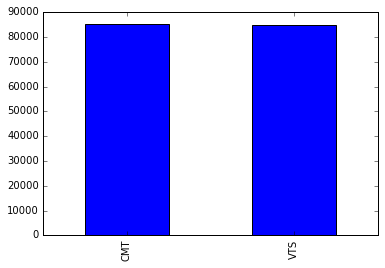

In [87]:
#Show the distribution in bar chart
df1['vendor_id'].value_counts().plot(kind='bar')

In [88]:
#Check categorical variable rate_code
df1['rate_code'].value_counts()

1    166580
2      2934
5       339
3       240
4       120
0        25
6         1
Name: rate_code, dtype: int64

In [89]:
#Show the mode of rate_code
df1['rate_code'].mode()

0    1
dtype: object

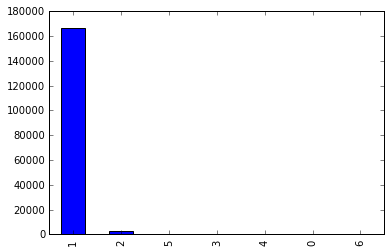

In [90]:
# Show the corresponding bar chart
df1['rate_code'].value_counts().plot(kind='bar')

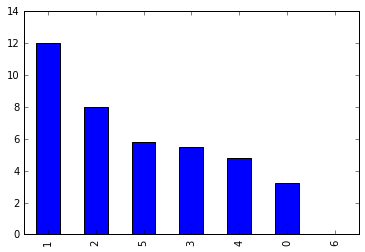

In [91]:
#Show the bar chart in log scale
np.log(df1['rate_code'].value_counts()).plot(kind='bar')

In [92]:
# Check numeric variable passenger_count
df1['passenger_count'].describe()
df1['passenger_count'].value_counts()

1.0    119915
2.0     23119
5.0      9924
3.0      7190
6.0      6574
4.0      3516
0.0         1
Name: passenger_count, dtype: int64

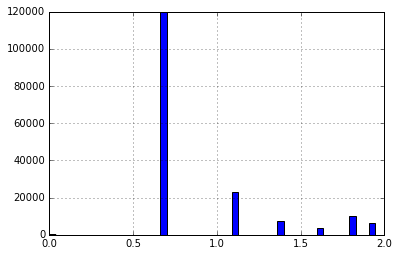

In [93]:
#Plot the histogram of the passenger_count (after log scale)
np.log(df1['passenger_count']+1).hist(bins=50)

In [94]:
#Check numeric variable trip_time_in_secs
df1['trip_time_in_secs'].describe()

count    1.702390e+05
mean     7.788995e+02
std      1.041122e+04
min      0.000000e+00
25%      3.610000e+02
50%      6.000000e+02
75%      9.600000e+02
max      4.290204e+06
Name: trip_time_in_secs, dtype: float64

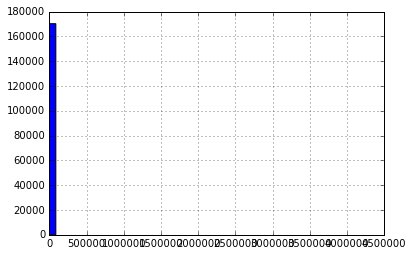

In [95]:
#Plot the histogram of trip_time_in_secs
df1['trip_time_in_secs'].hist(bins=50)
np.log(df1['trip_time_in_secs']+1).hist(bins=50)

In [96]:
#Plot the kernel density estimate of trip_time_in_secs
#Since plotting the kernel density estimate is relatively slow, we sample the data to draw it; you can change the sampling ratio as necessary.
sample_ratio = 0.01
sample_size = np.round(df1.shape[0] * sample_ratio)
sample_rows = np.random.choice(df1.index.values, sample_size)
df1_sample = df1.ix[sample_rows]
df1_sample.shape

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1702, 24)

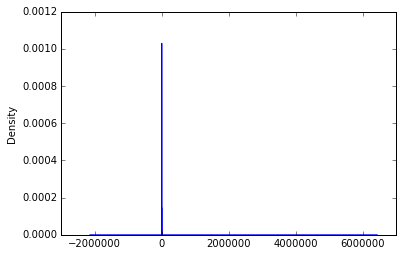

In [97]:
#Draw the kernel density estimate for the column trip_time_in_secs in df1_sample
df1_sample['trip_time_in_secs'].plot(kind='kde', style='b-')
df1['trip_time_in_secs'].plot(kind='kde', style='b-')

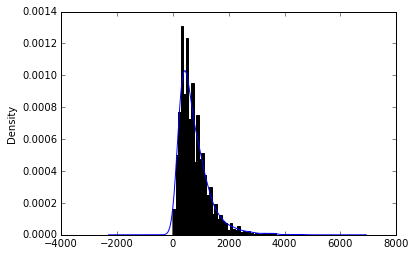

In [98]:
#Show histogram and kernel density estimate plot simultaneously
df1_sample['trip_time_in_secs'].hist(bins=50, color='k', normed=True)
df1_sample['trip_time_in_secs'].plot(kind='kde', style='b-')

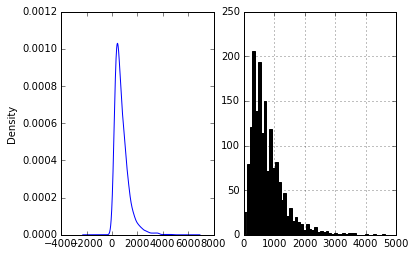

In [99]:
#Or we can show two plots together, but each one is a separate subplot
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
df1_sample['trip_time_in_secs'].plot(ax=ax1,kind='kde', style='b-')
df1_sample['trip_time_in_secs'].hist(ax=ax2, bins=50, color='k')

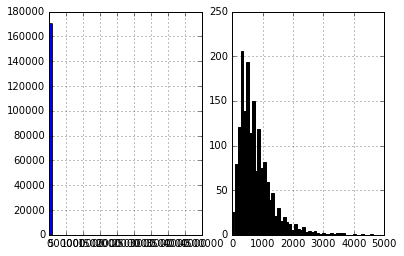

In [100]:
#Compare histograms of df1 and df1_sample
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
df1['trip_time_in_secs'].hist(ax=ax1, bins=50, color='b')
df1_sample['trip_time_in_secs'].hist(ax=ax2, bins=50, color='k')

In [101]:
#In the following we show sum basic functions to compute statistics

print(df1['trip_time_in_secs'].mean())
print(df1['trip_time_in_secs'].median())
print(df1['trip_time_in_secs'].std())
print(df1['trip_time_in_secs'].skew())
print(df1['trip_time_in_secs'].sum())
print(df1['trip_time_in_secs'].var())
print(df1['trip_time_in_secs'].quantile(0.25))
print(df1['trip_time_in_secs'].quantile(0.5))
df1['trip_time_in_secs'].describe()

778.899453122
600.0
10411.2158784
410.810798365
132599064.0
108393416.067
361.0
600.0


count    1.702390e+05
mean     7.788995e+02
std      1.041122e+04
min      0.000000e+00
25%      3.610000e+02
50%      6.000000e+02
75%      9.600000e+02
max      4.290204e+06
Name: trip_time_in_secs, dtype: float64

In [102]:
#Check numeric variable trip_distance
df1['trip_distance'].describe()

count    170239.000000
mean          2.889649
std           3.376613
min           0.000000
25%           1.050000
50%           1.800000
75%           3.200000
max          77.800000
Name: trip_distance, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x7f81aee35f50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f81adef1d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f81ac361090>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f81ac598a10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f81adef1190>,
  <matplotlib.lines.Line2D at 0x7f81aee35c10>]}

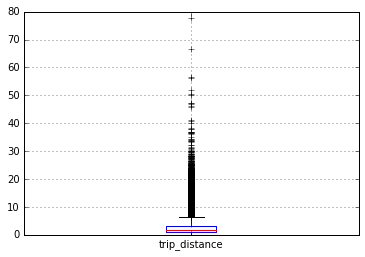

In [103]:
#Draw boxplot
df1.boxplot(column='trip_distance',return_type='dict')

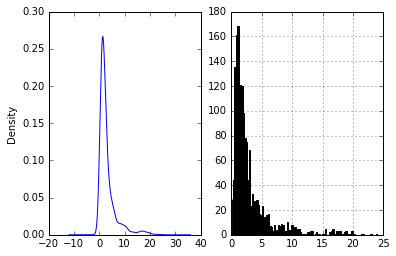

In [104]:
#Show the distribution of trip_distance by showing two plots together. We also use df1_sample since kde plot drawing ins slow
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
df1_sample['trip_distance'].plot(ax=ax1,kind='kde', style='b-')
df1_sample['trip_distance'].hist(ax=ax2, bins=100, color='k')

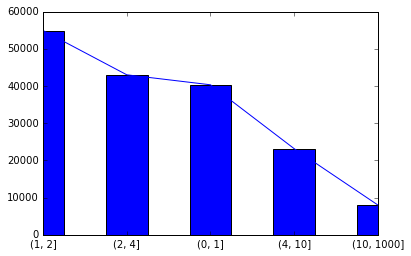

In [105]:
#Calculate the number of trip_distance in different groups
trip_dist_bins = [0, 1, 2, 4, 10, 1000]
df1['trip_distance']
trip_dist_bin_id = pd.cut(df1['trip_distance'], trip_dist_bins)
trip_dist_bin_id
trip_dist_bin_id.value_counts()
trip_dist_bin_id.value_counts().plot(kind='bar')
trip_dist_bin_id.value_counts().plot(kind='line')

###Step 5. Explore the relationship between two or more columns

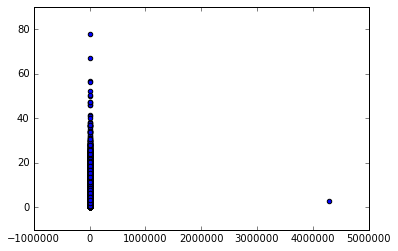

In [106]:
#Explore the relationship between trip_time_in_secs and trip_distance using scatter plot
plt.scatter(df1['trip_time_in_secs'], df1['trip_distance'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81af6fe210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f81ae053110>]], dtype=object)

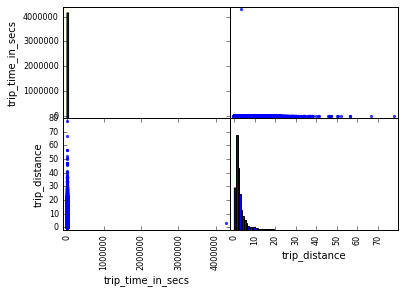

In [107]:
#Plot histograms and scatter plots simultaneously
df1_2col = df1[['trip_time_in_secs','trip_distance']]
pd.scatter_matrix(df1_2col, diagonal='hist', color='b', alpha=0.7, hist_kwds={'bins':100})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a01d7b90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f819fb1c650>]], dtype=object)

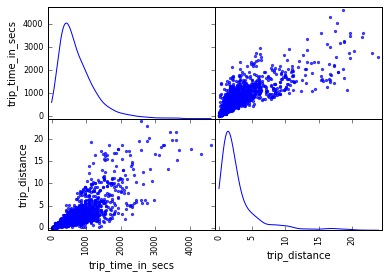

In [108]:
#Replace the diagonal plots as kde on the sampled data set (we do not do it on the original data data as kde plot drawing is relatively slow)
df1_sample_2col = df1_sample[['trip_time_in_secs','trip_distance']]
pd.scatter_matrix(df1_sample_2col, diagonal='kde', color='b', alpha=0.7)

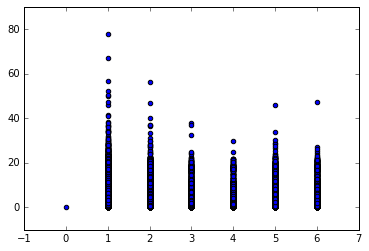

In [109]:
#Explore the relationship between rate_code and trip_distance using scatter plot
plt.scatter(df1['passenger_count'], df1['trip_distance'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a54e40d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f81a4d58d10>]], dtype=object)

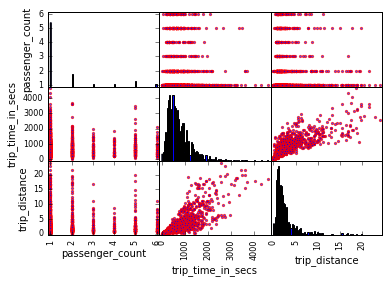

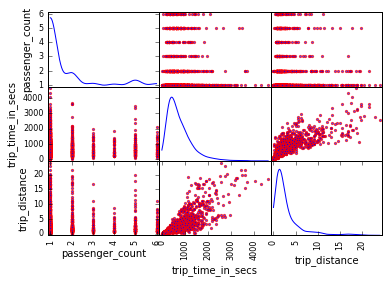

In [110]:
#Explore multiple columns simultaneously using scatter plot and histogram and kde
df1_sample_3col = df1_sample[['passenger_count', 'trip_time_in_secs', 'trip_distance']]
pd.scatter_matrix(df1_sample_3col, diagonal='hist', color='r', alpha=0.7, hist_kwds={'bins':100})
pd.scatter_matrix(df1_sample_3col, diagonal='kde', color='r', alpha=0.7)

In [111]:
#Compute the correlation between trip_time_in_secs and trip_distance
print df1[['trip_time_in_secs', 'trip_distance']].corr()

                   trip_time_in_secs  trip_distance
trip_time_in_secs           1.000000       0.041092
trip_distance               0.041092       1.000000


In [112]:
#Compute the correlation involving 3 variables: trip_time_in_secs, trip_distance, and passenger_count
print df1[['trip_time_in_secs', 'trip_distance', 'passenger_count']].corr()

                   trip_time_in_secs  trip_distance  passenger_count
trip_time_in_secs           1.000000       0.041092         0.005023
trip_distance               0.041092       1.000000         0.017678
passenger_count             0.005023       0.017678         1.000000


In [113]:
#Compute the covariance between trip_time_in_secs and trip_distance
print df1[['trip_time_in_secs', 'trip_distance']].cov()

                   trip_time_in_secs  trip_distance
trip_time_in_secs       1.083934e+08    1444.569733
trip_distance           1.444570e+03      11.401513


In [114]:
#Compute the covariance involving 3 variables
print df1[['trip_time_in_secs', 'trip_distance', 'passenger_count']].cov()

                   trip_time_in_secs  trip_distance  passenger_count
trip_time_in_secs       1.083934e+08    1444.569733        71.837775
trip_distance           1.444570e+03      11.401513         0.081995
passenger_count         7.183778e+01       0.081995         1.886806


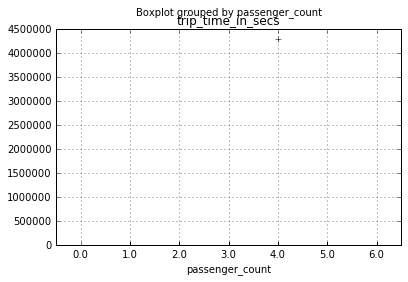

In [115]:
#Explore the relationship between trip_time_in_secs and passenger_count
df1['passenger_count'].value_counts()
df1.boxplot(column='trip_time_in_secs', by='passenger_count')

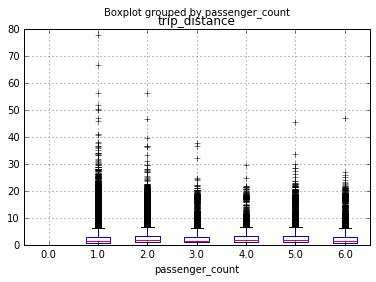

In [116]:
#Explore the relationship between trip_distance and passenger_count
df1.boxplot(column='trip_distance', by='passenger_count')

vendor_id
CMT    109502.0
VTS    181349.0
Name: passenger_count, dtype: float64


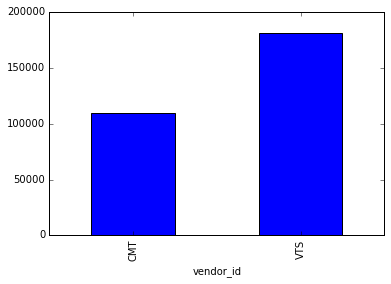

In [117]:
#Check the sum of passengers for each vendor
vendor_passenger_sum = df1.groupby('vendor_id').passenger_count.sum()
print vendor_passenger_sum
vendor_passenger_sum.plot(kind='bar')

###Step 6. Feature engineering

In [118]:
#Convert categorical features to a sequence of dummy features
df1['rate_code'].value_counts()

df1_rate_code_dummy = pd.get_dummies(df1['rate_code'], prefix='rate_code_dummy')
df1_rate_code_dummy.head()
#df1['rate_code'].head()

,rate_code_dummy_0,rate_code_dummy_1,rate_code_dummy_2,rate_code_dummy_3,rate_code_dummy_4,rate_code_dummy_5,rate_code_dummy_6
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [119]:
#Join the dummy variables back to the original data frame
df1_with_dummy = df1.join(df1_rate_code_dummy)
df1_with_dummy

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tipped,tip_class,rownum,rate_code_dummy_0,rate_code_dummy_1,rate_code_dummy_2,rate_code_dummy_3,rate_code_dummy_4,rate_code_dummy_5,rate_code_dummy_6
0,08BAA2264C1C39B35299406F58E14598,F664D1573DECA9A5882310DA6E717337,CMT,1,N,2013-04-23T13:56:00.0000000,2013-04-23T14:04:00.0000000,1.0,505.0,1.40,...,1.0,1.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0053334C798EC6C8E637657962030F99,9EF690115D60940E7A8039A67542642E,VTS,2,,2013-01-26T18:55:00.0000000,2013-01-26T19:36:00.0000000,6.0,2460.0,17.39,...,1.0,2.0,1000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,024A0232F4905854035179D87C8BEAAA,28C5A9259CE80BCF953D855C58AF649E,CMT,1,N,2013-09-25T15:13:28.0000000,2013-09-25T15:43:31.0000000,1.0,1802.0,10.20,...,1.0,3.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,275454BAC5AEC63B0730FFEE2E915175,F665D8F3D7C62A7EE679CDF4394BACDD,VTS,1,,2013-10-03T22:34:00.0000000,2013-10-03T23:22:00.0000000,1.0,2880.0,34.18,...,1.0,4.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,09459F826A44348760E74FCD3BFBDB72,5D2FE6803D43C44A4F21C7389B5D97D7,VTS,1,,2013-07-28T14:01:00.0000000,2013-07-28T14:55:00.0000000,1.0,3240.0,28.03,...,0.0,0.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,08CED443036B7C30AD47C5D1AE3A34F7,4AC11012522AE5B31F862A094B9E8642,CMT,1,N,2013-07-26T00:52:01.0000000,2013-07-26T01:04:20.0000000,1.0,738.0,3.60,...,1.0,1.0,2000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,00B99071EE4DC8266384113B91E6AC13,081B28EDA7F73E5E2C97573F0DBAC25D,CMT,1,N,2013-12-17T14:52:37.0000000,2013-12-17T15:36:29.0000000,1.0,2632.0,11.10,...,1.0,2.0,2000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,03BEA0DB03A589C5C77BD4152A2F4396,19269BF987DE73F57F5C69DE9AD848BB,VTS,1,,2013-08-06T11:30:00.0000000,2013-08-06T12:01:00.0000000,6.0,1860.0,15.63,...,1.0,3.0,2000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,5BDCEE106EAFB3059A5494CDECB33DBB,DB2E3AAFE3505DA442EA2CE069723973,CMT,2,N,2013-06-03T17:18:15.0000000,2013-06-03T18:35:20.0000000,1.0,4624.0,19.00,...,1.0,4.0,2000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,124FF99D9330F4366E806B3BFB039D71,DAFD2C5619DEF1493D84E87A95D3EC76,VTS,1,,2013-11-10T04:17:00.0000000,2013-11-10T04:37:00.0000000,1.0,1200.0,6.50,...,0.0,0.0,2000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [120]:
#Remove the original column rate_code in df1_with_dummy
df1_with_dummy.drop('rate_code', axis=1, inplace=True)
df1_with_dummy.head(5)

,medallion,hack_license,vendor_id,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,tipped,tip_class,rownum,rate_code_dummy_0,rate_code_dummy_1,rate_code_dummy_2,rate_code_dummy_3,rate_code_dummy_4,rate_code_dummy_5,rate_code_dummy_6
0,08BAA2264C1C39B35299406F58E14598,F664D1573DECA9A5882310DA6E717337,CMT,N,2013-04-23T13:56:00.0000000,2013-04-23T14:04:00.0000000,1.0,505.0,1.40,-73.975140,...,1.0,1.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0053334C798EC6C8E637657962030F99,9EF690115D60940E7A8039A67542642E,VTS,,2013-01-26T18:55:00.0000000,2013-01-26T19:36:00.0000000,6.0,2460.0,17.39,-73.984474,...,1.0,2.0,1000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,024A0232F4905854035179D87C8BEAAA,28C5A9259CE80BCF953D855C58AF649E,CMT,N,2013-09-25T15:13:28.0000000,2013-09-25T15:43:31.0000000,1.0,1802.0,10.20,-73.991264,...,1.0,3.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,275454BAC5AEC63B0730FFEE2E915175,F665D8F3D7C62A7EE679CDF4394BACDD,VTS,,2013-10-03T22:34:00.0000000,2013-10-03T23:22:00.0000000,1.0,2880.0,34.18,-73.954880,...,1.0,4.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,09459F826A44348760E74FCD3BFBDB72,5D2FE6803D43C44A4F21C7389B5D97D7,VTS,,2013-07-28T14:01:00.0000000,2013-07-28T14:55:00.0000000,1.0,3240.0,28.03,-73.782630,...,0.0,0.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [121]:
#Create bins based on trip_distance
trip_dist_bins = [0, 1, 2, 4, 10, 40]
trip_dist_bin_id = pd.cut(df1['trip_distance'], trip_dist_bins)
trip_dist_bin_id.head(5)

0      (1, 2]
1    (10, 40]
2    (10, 40]
3    (10, 40]
4    (10, 40]
Name: trip_distance, dtype: category
Categories (5, object): [(0, 1] < (1, 2] < (2, 4] < (4, 10] < (10, 40]]

In [122]:
#Convert binning to a sequence of boolean variables
df1_bin_bool = pd.get_dummies(trip_dist_bin_id, prefix='trip_dist')
df1_bin_bool.head(5)

,"trip_dist_(0, 1]","trip_dist_(1, 2]","trip_dist_(2, 4]","trip_dist_(4, 10]","trip_dist_(10, 40]"
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0


In [123]:
#Join the dummy variables back to the original data frame
df1_with_bin_bool = df1.join(df1_bin_bool)
df1_with_bin_bool.head(5)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,total_amount,tip_amount,tipped,tip_class,rownum,"trip_dist_(0, 1]","trip_dist_(1, 2]","trip_dist_(2, 4]","trip_dist_(4, 10]","trip_dist_(10, 40]"
0,08BAA2264C1C39B35299406F58E14598,F664D1573DECA9A5882310DA6E717337,CMT,1,N,2013-04-23T13:56:00.0000000,2013-04-23T14:04:00.0000000,1.0,505.0,1.40,...,10.00,2.00,1.0,1.0,1000.0,0.0,1.0,0.0,0.0,0.0
1,0053334C798EC6C8E637657962030F99,9EF690115D60940E7A8039A67542642E,VTS,2,,2013-01-26T18:55:00.0000000,2013-01-26T19:36:00.0000000,6.0,2460.0,17.39,...,60.50,8.00,1.0,2.0,1000.0,0.0,0.0,0.0,0.0,1.0
2,024A0232F4905854035179D87C8BEAAA,28C5A9259CE80BCF953D855C58AF649E,CMT,1,N,2013-09-25T15:13:28.0000000,2013-09-25T15:43:31.0000000,1.0,1802.0,10.20,...,48.52,11.19,1.0,3.0,1000.0,0.0,0.0,0.0,0.0,1.0
3,275454BAC5AEC63B0730FFEE2E915175,F665D8F3D7C62A7EE679CDF4394BACDD,VTS,1,,2013-10-03T22:34:00.0000000,2013-10-03T23:22:00.0000000,1.0,2880.0,34.18,...,132.49,26.00,1.0,4.0,1000.0,0.0,0.0,0.0,0.0,1.0
4,09459F826A44348760E74FCD3BFBDB72,5D2FE6803D43C44A4F21C7389B5D97D7,VTS,1,,2013-07-28T14:01:00.0000000,2013-07-28T14:55:00.0000000,1.0,3240.0,28.03,...,87.16,0.00,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,1.0


###Step 7. Build Machine Learning Models
Model 1: Binary Classification: Tipped or Not
Model 2: Multiclass Classification: Tipped_Class
Model 3: Linear Regression: Tip_Amount

In [124]:
#Model 1: Binary classification

#check some candidate predictors
print df1['payment_type'].describe()
print df1['payment_type'].value_counts()
print df1['trip_distance'].describe()

count     170239
unique         5
top          CRD
freq       91745
Name: payment_type, dtype: object
CRD    91745
CSH    77793
NOC      389
UNK      176
DIS      136
Name: payment_type, dtype: int64
count    170239.000000
mean          2.889649
std           3.376613
min           0.000000
25%           1.050000
50%           1.800000
75%           3.200000
max          77.800000
Name: trip_distance, dtype: float64


In [125]:
##dummify payment_type
df1_payment_type_dummy = pd.get_dummies(df1['payment_type'], prefix='payment_type_dummy')
df1_vendor_id_dummy = pd.get_dummies(df1['vendor_id'], prefix='vendor_id_dummy')

In [126]:
##create data frame for the modeling
cols_to_keep = ['tipped', 'trip_distance', 'passenger_count']
data = df1[cols_to_keep].join([df1_payment_type_dummy,df1_vendor_id_dummy])

X = data.iloc[:,1:]
Y = data.tipped

In [127]:
#Training and testing 60-40 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [128]:
#Logistic Regression in traing set
model = LogisticRegression()
logit_fit = model.fit(X_train, Y_train)
print ('Coefficients: \n', logit_fit.coef_)
Y_train_pred = logit_fit.predict(X_train)

('Coefficients: \n', array([[-0.05133172, -0.008217  ,  5.45355932, -6.63170116, -1.79058312,
        -2.79956737,  4.60387707, -0.33341385, -0.83100141]]))


In [129]:
#Score testing data set
Y_test_pred = logit_fit.predict(X_test)

In [130]:
#Evaluation metrics
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(Y_train, Y_train_pred)
print fpr_train, tpr_train, thresholds_train

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(Y_test, Y_test_pred) 
print fpr_test, tpr_test, thresholds_test

#AUC
print metrics.auc(fpr_train,tpr_train)
print metrics.auc(fpr_test,tpr_test)

#Confusion Matrix
print metrics.confusion_matrix(Y_train,Y_train_pred)
print metrics.confusion_matrix(Y_test,Y_test_pred)

[ 0.          0.03372081  1.        ] [ 0.          0.99994397  1.        ] [ 2.  1.  0.]
[ 0.          0.03342893  1.        ] [ 0.          0.99983179  1.        ] [ 2.  1.  0.]
0.983111577209
0.983201427013
[[46966  1639]
 [    3 53535]]
[[31343  1084]
 [    6 35663]]


In [131]:
#Model 2: Multiclass classification
##create data frame for the modeling
cols_to_keep = ['tip_class', 'trip_distance', 'passenger_count']
data = df1[cols_to_keep].join([df1_payment_type_dummy,df1_vendor_id_dummy])

X = data.iloc[:,1:]
Y = data.tip_class

#Training and testing 60-40 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

model = LogisticRegression()
mlogit_fit = model.fit(X_train, Y_train)
print ('Coefficients: \n', mlogit_fit.coef_)
Y_train_pred = mlogit_fit.predict(X_train)

#Score testing data set
Y_test_pred = mlogit_fit.predict(X_test)

#Evaluation metrics
accuracy_train = sum(Y_train == Y_train_pred)/X_train.shape[0]
accuracy_test = sum(Y_test == Y_test_pred)/X_test.shape[0]
print accuracy_train,accuracy_test

#Confusion Matrix
print metrics.confusion_matrix(Y_train,Y_train_pred)
print metrics.confusion_matrix(Y_test,Y_test_pred)

('Coefficients: \n', array([[ 0.05133302,  0.00821731, -5.45355922,  6.63170121,  1.79058323,
         2.79956745, -4.60387722,  0.33341392,  0.83100153],
       [-0.46495102,  0.01574466,  5.35923288, -6.56693086, -1.59082014,
        -2.74528777,  4.68090915, -0.35272767, -0.51016907],
       [ 0.28394317, -0.01878623,  2.10392295, -5.44760439, -0.51547824,
        -2.08007402,  1.86875105, -2.00217094, -2.06831171],
       [ 0.38365427, -0.01617386,  1.5538791 , -5.88680879, -0.28695789,
        -2.04335644,  1.07615969, -2.70066484, -2.88641948],
       [ 0.20515091, -0.35762564, -0.58928044, -3.24449184, -0.10148149,
        -0.82575623, -0.07438088, -2.21006169, -2.6253292 ]]))
0.942590290084 0.942713228383
[[46966  1502   134     3     0]
 [    2 48322   370     1     0]
 [    1  2717   983     1     0]
 [    0   157   929     8     0]
 [    0    17    24     6     0]]
[[31342   995    85     5     0]
 [    4 32251   225     3     0]
 [    1  1795   598     1     0]
 [    1   10

In [132]:
#Model 3: Regression Model
##create data frame for the modeling
cols_to_keep = ['tip_amount', 'trip_distance', 'passenger_count']
data = df1[cols_to_keep].join([df1_payment_type_dummy,df1_vendor_id_dummy])

X = data.iloc[:,1:]
Y = data.tip_amount

#Training and testing 60-40 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)


model = linear_model.LinearRegression()
lm_fit = model.fit(X_train, Y_train)
print ('Coefficients: \n', lm_fit.coef_)
Y_train_pred = lm_fit.predict(X_train)

#Score testing data set
Y_test_pred = lm_fit.predict(X_test)

#Evaluation Matrics
MSE_train = np.mean((Y_train_pred - Y_train)**2)
MSE_test = np.mean((Y_test_pred - Y_test)**2)
R_Sq_train = lm_fit.score(X_train,Y_train)
R_Sq_test = lm_fit.score(X_test,Y_test)

print ('Mean Square Error in training: %.4f' % MSE_train)
print ('Mean Square Error in testing: %.4f' % MSE_test)

print ('R-Square in training: %.4f' % R_Sq_train)
print ('R-Square in testing: %.4f' % R_Sq_test)

('Coefficients: \n', array([ 0.28964702, -0.00656444,  1.47556815, -0.88211548, -0.97664875,
       -0.9229739 ,  1.30616999,  0.03657249, -0.03657249]))
Mean Square Error in training: 1.9501
Mean Square Error in testing: 2.0034
R-Square in training: 0.5641
R-Square in testing: 0.5608


###Step 8. Build Web Service API and consume it in Python
Here we use the binary logistic model as an example
Make sure the scikit-learn version in your local machine is 0.15.1

In [133]:
#Find your workspaca credentials from Azure ML studio settings
workspaceid = '5ef876a4f3ca460292afcd629808b823'
auth_token = '810080c867b84e90be61bdf9b782dcbc'

#Create Web Service
@services.publish(workspaceid, auth_token) 
@services.types(trip_distance = float, passenger_count = float, payment_type_dummy_CRD = float, payment_type_dummy_CSH=float, payment_type_dummy_DIS = float, payment_type_dummy_NOC = float, payment_type_dummy_UNK = float, vendor_id_dummy_CMT = float, vendor_id_dummy_VTS = float)
@services.returns(int) #0, or 1
def predictNYCTAXI(trip_distance, passenger_count, payment_type_dummy_CRD, payment_type_dummy_CSH,payment_type_dummy_DIS, payment_type_dummy_NOC, payment_type_dummy_UNK, vendor_id_dummy_CMT, vendor_id_dummy_VTS ):
    inputArray = [trip_distance, passenger_count, payment_type_dummy_CRD, payment_type_dummy_CSH, payment_type_dummy_DIS, payment_type_dummy_NOC, payment_type_dummy_UNK, vendor_id_dummy_CMT, vendor_id_dummy_VTS]
    return logit_fit.predict(inputArray)

#Get web service credentials
url = predictNYCTAXI.service.url
api_key =  predictNYCTAXI.service.api_key

print url
print api_key

@services.service(url, api_key)
@services.types(trip_distance = float, passenger_count = float, payment_type_dummy_CRD = float, payment_type_dummy_CSH=float,payment_type_dummy_DIS = float, payment_type_dummy_NOC = float, payment_type_dummy_UNK = float, vendor_id_dummy_CMT = float, vendor_id_dummy_VTS = float)
@services.returns(float)
def NYCTAXIPredictor(trip_distance, passenger_count, payment_type_dummy_CRD, payment_type_dummy_CSH,payment_type_dummy_DIS, payment_type_dummy_NOC, payment_type_dummy_UNK, vendor_id_dummy_CMT, vendor_id_dummy_VTS ):
    pass

https://ussouthcentral.services.azureml.net/workspaces/5ef876a4f3ca460292afcd629808b823/services/8060d2b00eb4482e93a810f4cb8789ce/execute?api-version=2.0
rdu/+dR9JmNmgG9RNBowXYuIDiRLhBSg46VgASfUD+zsUV8LjSgdXIaOSUoyqZC6qiYVaOzJRoWPRwy299dARw==


In [135]:
#Call Web service API
#You have to wait 5-10 seconds, some latency here
NYCTAXIPredictor(1,2,1,0,0,0,0,0,1)

RuntimeError: Error 0085: The following error occurred during script evaluation, please view the output log for more information:
---------- Start of error message from Python interpreter ----------
Caught exception while executing function: Traceback (most recent call last):
  File "\server\InvokePy.py", line 97, in executeScript
    outframe = mod.azureml_main(*inframes)
  File "\temp\-1617057529.py", line 1102, in azureml_main
    results.append(__user_function(trip_distance, passenger_count, payment_type_dummy_CRD, payment_type_dummy_CSH, payment_type_dummy_DIS, payment_type_dummy_NOC, payment_type_dummy_UNK, vendor_id_dummy_CMT, vendor_id_dummy_VTS))
  File "<ipython-input-133-58fddc70610c>", line 11, in predictNYCTAXI
  File "C:\pyhome\lib\site-packages\sklearn\linear_model\base.py", line 220, in predict
    return self.classes_[indices]
  File "C:\pyhome\lib\site-packages\sklearn\svm\base.py", line 726, in classes_
    return self._enc.classes_
AttributeError: 'LogisticRegression' object has no attribute '_enc'


---------- End of error message from Python  interpreter  ----------